Cameron Wood <br>
DTSA 5509 Final Project

### **Project Rundown**

The EMNIST (Extended Modified National Institute of Standards and Technology) Letters Dataset is an extension of the well-known MNIST dataset, which is the bread and butter of machine learning benchmarking. What sets EMNIST apart is its larger size and, as the name suggests, its inclusion of handwritten letters. This project will focus on the letter component within this extended dataset. </br>

Image processing often relies on deep learning, which is CPU and GPU intensive. Through Supervised Learning, this project will show how we can create robust Classification models for handwritten letters. These models are more efficient and can be used on everyday machines, which would make them more accessible and useful for a broader audience. 

### **Data Description**

The EMNIST Dataset was derived from the NIST Special Database 19 and converted to the same format and structure as the MNIST dataset. The original NIST Special Database 19 was currated from 3600 writers, consists of 810,000 character images and their respective true labels. </br>

More details about the collection and conversion process is described in *EMNIST: an extension of MNIST to handwritten letters* by Gregory Cohen, et al. The data itself can be found within the paper referenced. </br>

In the EMNIST Letters dataset, there are 88,800 samples in 26 classes representing every letter in the alphabet, upper- and lower-case. The data is stored in a binary format that describes the image in terms of 8-bit gray-scale resolution. All images are 28x28 pixels in size. </br>

#### References: </br>
Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373 </br>


### **Data Cleaning**

First we can run the cell below to get all of the necessary packages.

In [1]:
# Importing Packages

import math
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Importing all necessary libraries

from math import exp
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

ModuleNotFoundError: No module named 'sklearn'

And then we can load in the data and check out what we're working with. We'll want to take note that the test dataset does not contain all of the letters in the alphabet, so we will just be using the training dataset and splitting it.

In [3]:
# Loading in the Dataset
data = pd.read_csv('eminst\emnist-letters-train.csv')

In [4]:
# Showing Data header
data.head()

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It looks like our column header for our 'labels' is named '23' in the data, so we can fix that for data set. This will make it easier to reference later on in the code. </b>

We also notice that the labels are listed as integers 1-26 representing the entire alphabet. We will maintain this labeling method for ease of use.

In [5]:
#Renaming Labels Column
data = data.rename({'23':'labels'}, axis='columns')

# We'll also want to rename all the pixel columns to be representative of that

count = 0

for i in data.columns:
    if (i != 'labels'):
        newName = 'pixel' + str(count)
        data = data.rename({i:newName}, axis='columns')
        count += 1

In [6]:
#Checking the training data
data.head()

,labels,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we'll want to check for any null values, and to make sure that the data types align with what we're expecting. This is so our models don't break down the line.

In [7]:
# Checking for Null Values
NullVal = data.isnull().sum()
print("For Train Data: ")
print(NullVal[NullVal != 0])

For Train Data: 
Series([], dtype: int64)


In [8]:
# Checking Data Types for the Data
print("Train Data: ")
print(data.info())

Train Data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88799 entries, 0 to 88798
Columns: 785 entries, labels to pixel783
dtypes: int64(785)
memory usage: 531.8 MB
None


Lastly, we'll want to ensure that our pixel values contain intensity values, and that our training data has all 26 letters in it.

        pixel0   pixel1   pixel2        pixel3        pixel4        pixel5  \
count  88799.0  88799.0  88799.0  88799.000000  88799.000000  88799.000000   
mean       0.0      0.0      0.0      0.000011      0.003987      0.016757   
std        0.0      0.0      0.0      0.003356      0.544042      1.547695   
min        0.0      0.0      0.0      0.000000      0.000000      0.000000   
25%        0.0      0.0      0.0      0.000000      0.000000      0.000000   
50%        0.0      0.0      0.0      0.000000      0.000000      0.000000   
75%        0.0      0.0      0.0      0.000000      0.000000      0.000000   
max        0.0      0.0      0.0      1.000000    107.000000    213.000000   

             pixel6        pixel7        pixel8        pixel9  ...  pixel774  \
count  88799.000000  88799.000000  88799.000000  88799.000000  ...   88799.0   
mean       0.024640      0.021487      0.017140      0.010383  ...       0.0   
std        1.915987      1.803280      1.620203      1.13

Text(0.5, 1.0, 'Histogram of EMNIST Data Set')

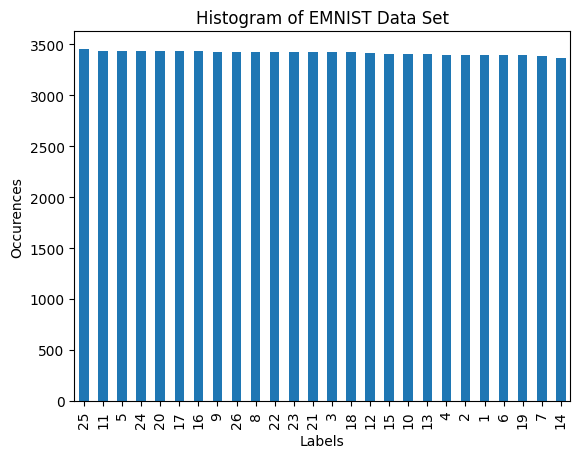

In [9]:
# For the training data
print(data.iloc[:, 1:].describe())

# Add Labels
ax = data['labels'].value_counts().plot(kind='bar')
ax.set_xlabel('Labels')
ax.set_ylabel('Occurences')
ax.set_title('Histogram of EMNIST Data Set')

Now that we have common column headers across both our dataset, we can now begin to work with the data in a meaningful way. EMNIST is a newer and less used dataset compared to MNIST, so it isn't as clean. We also confirmed that there are no null values within the dataset, and it consists of all integer values so we won't have any issues building our classification models. </br>

We also ensured that for the training and testing data sets have real intensity values in their pixels. We also ensured that there is an even distribution of letters within the data set, meaning we shouldn't have any bias towards a particular letter being trained on more significantly than any others. </br>

### **Exploratory Data Analysis**

Starting off we can split up our dataset into X, being our intensity values per pixel, and y, our labels. We'll also want to create an "alphabet" array to reference when accessing our labels.

In [10]:
# Seperating data from lables
X = data.drop('labels', axis=1).values
y = data['labels'].values

In [11]:
# Creating array of the alphabet
alphabet = []
for i in range(26):
    letter = chr(ord('a') + i)
    alphabet.append(letter)

Now we can use these new arrays to try plotting an example of what these handwritten letters look like. The images are flipped and rotated, so this is corrected in plotting. This fact won't change the classification models, since they are all in the same orientation.

In [12]:
# Method to view the letters at a specified index
def view_letter(data, label=None):
    fig = plt.figure(figsize=(3,3))
    data = np.flipud(data.reshape(28,28))
    data = np.rot90(data)
    data = np.rot90(data)
    data = np.rot90(data)
    plt.imshow(data, cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("True: {}".format(label), fontsize=16) 

In the cell below we can play with the index value and show a letter with it's true label.

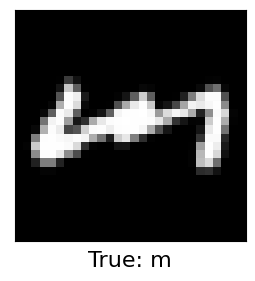

In [13]:
# Specify an index within the dataset and plot, along with specifying its true label
index = 5

view_letter(X[index], label=alphabet[y[index]-1])

Aside from the histogram showing the frequency of letters that show up in the dataset, found in the Data Cleaning section, we can also plot the intensities found across the dataset per letter.

Text(0.5, 1.0, 'Average Intensity Across EMNIST Dataset')

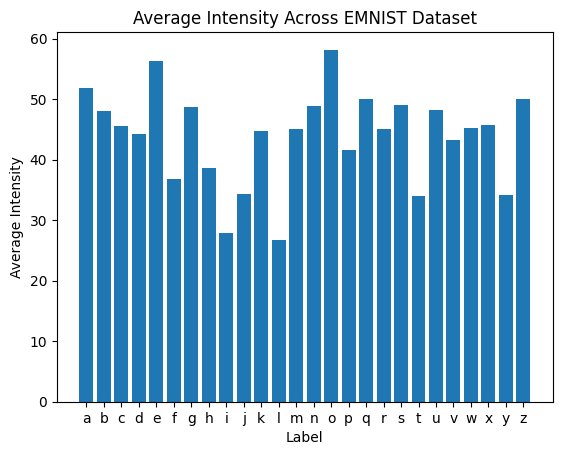

In [14]:
# Initialize arrays to store intensity values and counts
avg_intensity = np.zeros(26)
counts = np.zeros(26)

# Loop through X and gather information. Exlude intensity values of 0 which are black pixels

for i in range(len(X)):
    counts[y[i]-1] += 1
    avg_intensity[y[i]-1] += np.mean(X[i])

avg_intensity /= counts

# Plot a histogram of the intensity values

plt.bar(alphabet, avg_intensity)
plt.xlabel('Label')
plt.ylabel('Average Intensity')
plt.title('Average Intensity Across EMNIST Dataset')


We can see that there is quite a bit of variability in intensity between letters, but that is generally due to the size and shape of the letter written. For example, the letter i takes up significantly less space than something like a so the intensity is lower due to there being many more black pixels. </br>

Something else we can look at is the distribution of intensities across a particular letter. For this example I'll use the letter 'z' and compare it to 'o'.

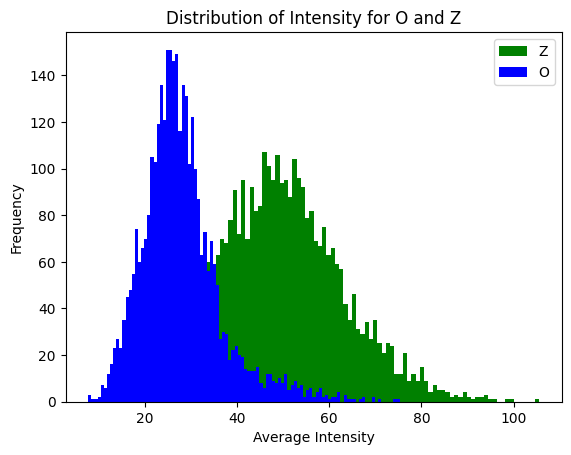

In [15]:
# Initialize Arrays
avg_intensity_z = []
avg_intensity_o = []

# Loop through the length and X and pick out any intensities that are Z or O
for i in range(len(X)):
    if y[i] == 26:
        avg_intensity_z.append(np.mean(X[i]))

    if y[i] == 9:
        avg_intensity_o.append(np.mean(X[i]))

# Plot the distribution of intensities                         
plt.hist(avg_intensity_z, bins=100, color='green', label='Z')
plt.hist(avg_intensity_o, bins=100, color='blue', label='O')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Intensity for O and Z')
plt.legend()

As one might expect, there is higher variability in how someone might write the z versus how someone might write the letter o. The purpose of showing these distributions also helps to show feature seperability, which will allow us to better classify the letters.

In conclusion, we have found that our dataset contains proper distribution of letters so we don't introduce any training bias towards any particular letter. We were also able to take a look at what the images look like, along with the distribution of their features (intensity values). </br>

As expected, smaller and small letters, like i and l will have lower intensity values than larger letters like o and z. We were also able to compare the distribution of intensities for the letters o and z to show variability. A simple letter like o has less variation in how people write it, versus something like z. Depending on the models you are interested in using, this feature seperability can help in classification. It's also important to note that these distributions follow a mostly normal distribution, meaning that the data set is truly random with differing variability. 

### **Models**

To start off, we'll split our data into training and testing sets. For our purposes we'll use a test size of 20%.

In [16]:
# Split the data into train and test sets with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

##### **Logistic Regression**

As our first classification model, we'll be using Logistic Regression.

In [17]:
# And now to train the model
LogReg = LogisticRegression(random_state=0, solver='liblinear').fit(X_train[:1000], y_train[:1000])

In [20]:
predictions = LogReg.predict(X_test[0:10])

score = LogReg.score(X_test[:10],y_test[:10])

print(score)

0.6


### **Results and Analysis**

### **Discussion and Conclusion**